In [1]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

--2024-10-16 17:19:59--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 16.12.18.10, 3.5.226.145
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|16.12.18.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812068227 (774M) [application/zip]
Saving to: ‘hydranets-data-2.zip’

hydranets-data-2.zi 100%[===================>] 774.45M  23.7MB/s    in 12s     

2024-10-16 17:20:12 (63.8 MB/s) - ‘hydranets-data-2.zip’ saved [812068227/812068227]



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

In [3]:
print(len(images))
print(len(depth))
print(len(seg))

1449
1449
1449


In [4]:
CMAP = np.load("cmap_nyud.npy")
print(len(CMAP))

256


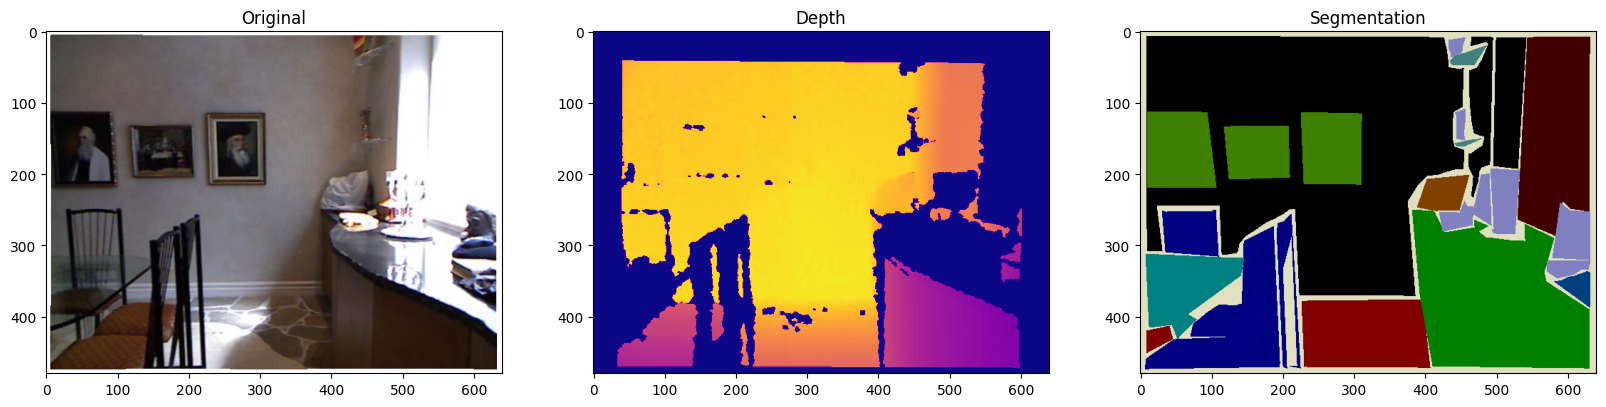

In [5]:
idx = np.random.randint(0,len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20,40))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap="plasma")
ax1.set_title("Depth")
ax2.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax2.set_title("Segmentation")
plt.show()

In [6]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   2   4   6   8  10  14  17  20  39 255]
12


## Dataloader

In [7]:
data_file = "train_list_depth.txt"
with open(data_file, "rb") as f:
  datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
root_dir = "/nyud"
masks_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [8]:
datalist[0]

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']

In [9]:
abs_paths = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_paths

['nyud/rgb/000003.png', 'nyud/masks/000003.png', 'nyud/depth/000003.png']

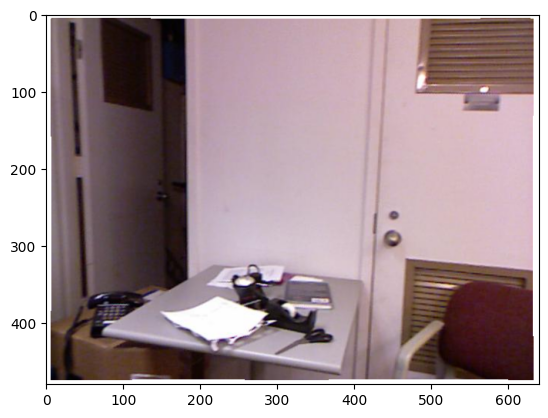

In [10]:
img_arr = np.array(Image.open(abs_paths[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud/masks/000003.png


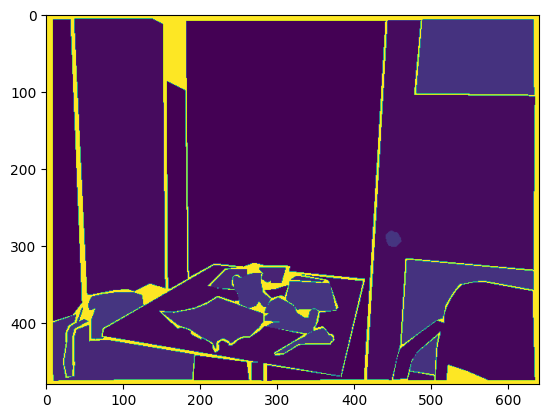

depth
nyud/depth/000003.png


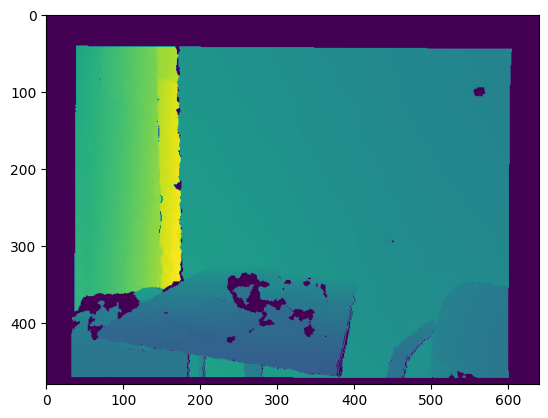

In [11]:
masks_names = ("segm", "depth")

for mask_name, mask_path in zip(masks_names, abs_paths[1:]):
    print(mask_name)
    print(mask_path)
    mask = np.array(Image.open(mask_path))
    plt.imshow(mask)
    plt.show()

In [12]:
from torch.utils.data import Dataset

class HydranetDataset(Dataset):

    def __init__(self, data_file, transform=None):
        with open(data_file, "rb") as f:
            datalist = f.readlines()
        self.datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
        self.root_dir = "nyud"
        self.transform = transform
        self.masks_names = ("segm", "depth")

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        abs_paths = [os.path.join(self.root_dir, rpath) for rpath in self.datalist[idx]]
        sample = {}
        sample["image"] = np.array(Image.open(abs_paths[0]))

        for mask_name, mask_path in zip(self.masks_names, abs_paths[1:]):
            mask = np.array(Image.open(mask_path))
            assert len(mask.shape) == 2, "Masks must be encoded without colourmap"
            sample[mask_name] = mask

        if self.transform:
            sample["names"] = self.masks_names
            sample = self.transform(sample)
            if "names" in sample:
                del sample["names"]
        return sample

### Normalization

In [13]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [14]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]
transform_common = [Normalise(*normalise_params), ToTensor()]

In [15]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [16]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [17]:
from torch.utils.data import DataLoader

trainloader = DataLoader(
    HydranetDataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

valloader = DataLoader(HydranetDataset(val_file, transform=transform_val,),
    batch_size=val_batch_size,
    shuffle=False, num_workers=4,
    pin_memory=True,
    drop_last=False,)

In [18]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, bias=bias, groups=groups)

In [19]:
def conv1x1(in_channels, out_channels, stride=1, dilation=0, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=dilation, bias=bias, groups=groups)

In [20]:
def batchnorm(num_features):
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

In [21]:
def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
  if act:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels),
                         nn.ReLU6(inplace=True))
  else:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels))

In [22]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
    super().__init__()
    intermed_planes = in_planes * expansion_factor
    self.residual = (in_planes == out_planes) and (stride == 1)
    self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                convbnrelu(intermed_planes, out_planes, 1, act=False))
  def forward(self, x):
    if self.residual:
      return x + self.output(x)
    else:
      return self.output(x)

In [23]:
class MobileNetv2(nn.Module):
    def __init__(self, return_idx=[6]):
        super().__init__()
        self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
        ]
        self.in_channels = 32
        self.num_layers = len(self.mobilenet_config)
        self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
        self.return_idx = [1, 2, 3, 4, 5, 6]

        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_channels = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1

        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))
        outs.append(self.layer3(outs[-1]))
        outs.append(self.layer4(outs[-1]))
        outs.append(self.layer5(outs[-1]))
        outs.append(self.layer6(outs[-1]))
        outs.append(self.layer7(outs[-1]))
        outs.append(self.layer8(outs[-1]))
        return [outs[idx] for idx in self.return_idx]

In [25]:
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<ipython-input-25-3e5f27ee2b22>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))


<All keys matched successfully>

## Decoder

In [26]:
def make_list(x):
  if isinstance(x, list):
    return x
  elif isinstance(x, tuple):
    return list(x)
  else:
    return [x]

In [27]:
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super().__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x

In [28]:
class MTLWRefineNet(nn.Module):
    def __init__(self, input_sizes, num_classes, agg_size=256, n_crp=4):
        super().__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        input_sizes = list(reversed((input_sizes)))

        self.collapse_ind = [[0, 1], [2, 3], 4, 5]

        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))
        return outs

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)

In [29]:
num_classes = (40, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)

## Train

In [30]:
from utils import InvHuberLoss
ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

In [31]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [32]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder),
          torch.optim.SGD(decoder.parameters(), lr=lr_decoder, momentum=momentum_decoder, weight_decay=weight_decay_decoder)]

In [33]:
n_epochs = 500

In [34]:
from model_helpers import Saver, load_state_dict
import operator
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [35]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder).cuda())

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

Model has 3070057 parameters


In [36]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))

In [37]:
from utils import AverageMeter
from tqdm import tqdm

In [38]:
def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        outputs = model(input)

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),
            )

        for opt in opts:
            opt.zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

In [39]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]
            outputs = model(input)
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

In [40]:
from utils import MeanIoU, RMSE

In [ ]:
crop_size = 400
batch_size = 4
val_batch_size = 4
val_every = 5
loss_coeffs = (0.5, 0.5)

for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)

    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_segm, crit_depth], trainloader, loss_coeffs)

    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, valloader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRE

Epoch 0


Loss 1.879 | Avg. Loss 2.248: 100%|██████████| 198/198 [00:25<00:00,  7.77it/s]
meaniou : 0.018180 | rmse : 1.197350:  41%|████▏     | 68/164 [01:13<01:41,  1.06s/it]